<a href="https://colab.research.google.com/github/SFStefenon/WBF-HE-YOLO/blob/main/WBF_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Archive.zip
!unzip /content/drive/MyDrive/insulator_v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/exp5/._train_batch11430.jpg  
  inflating: exp5/train_batch11432.jpg  
  inflating: __MACOSX/exp5/._train_batch11432.jpg  
  inflating: exp5/args.yaml          
  inflating: __MACOSX/exp5/._args.yaml  
  inflating: exp5/results.png        
  inflating: __MACOSX/exp5/._results.png  
  inflating: exp5/P_curve.png        
  inflating: __MACOSX/exp5/._P_curve.png  
   creating: exp5/weights/
  inflating: __MACOSX/exp5/._weights  
  inflating: exp5/events.out.tfevents.1680305313.node5.1549585.4  
  inflating: __MACOSX/exp5/._events.out.tfevents.1680305313.node5.1549585.4  
  inflating: exp5/val_batch2_pred.jpg  
  inflating: __MACOSX/exp5/._val_batch2_pred.jpg  
  inflating: exp5/labels_correlogram.jpg  
  inflating: __MACOSX/exp5/._labels_correlogram.jpg  
  inflating: exp5/val_batch0_labels.jpg  
  inflating: __MACOSX/exp5/._val_batch0_labels.jpg  
  inflating: exp5/F1_curve.png       
  inflating: __MACOSX/exp5/._F1

In [ ]:
from ultralytics import YOLO
models = []
models.append(YOLO('exp/weights/best.pt'))
for k in range(2,11):
    print(k)
    models.append(YOLO('exp'+str(k)+'/weights/last.pt'))

2
3
4
5
6
7
8
9
10


In [ ]:
models

In [ ]:
import os
dir_path = 'valid/images/'
files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

In [ ]:
predicts_all = []
for model in models:
    predicts = {}
    for file in files:
        predicts[file] = model(dir_path + file)
    predicts_all.append(predicts)

Streaming output truncated to the last 5000 lines.
image 1/1 /content/valid/images/160029d_JPG_jpg.rf.e701aba57f930e5b008da248311998b4.jpg: 640x640 1 flashover_damage, 5 good_insulators, 1 insulator_string, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/150714--2-d_JPG_jpg.rf.8039492bee435557647fb83120f275cd.jpg: 640x640 7 flashover_damages, 8 good_insulators, 1 insulator_string, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/150526d_JPG_jpg.rf.55536c462741e7c1323e0aab4a73a5be.jpg: 640x640 1 flashover_damage, 14 good_insulators, 1 insulator_string, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/151401h_jpg.rf.0d4756d91adb30dc584f5a9ed46d4550.jpg: 640x640 1 broken_shell, 22 good_insulators, 11.3ms
Speed: 0.5ms preprocess,

In [ ]:
import pickle
with open('preditos.pickle', 'wb') as handle:
    pickle.dump(predicts_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!pip install -q ensemble-boxes

In [ ]:
interesse = files[3]

boxes_list = []
scores_list = []
labels_list = []
for k in predicts_all:
    boxes_list.append(k[interesse][0].boxes.xyxyn)
    scores_list.append(k[interesse][0].boxes.conf)
    labels_list.append(k[interesse][0].boxes.cls)

In [ ]:
from ensemble_boxes import *
print(scores_list[0])

tensor([0.9518, 0.9467, 0.9387, 0.9372, 0.9328, 0.9269, 0.9259, 0.9166, 0.9160, 0.9131, 0.9032, 0.9011, 0.8728, 0.7896, 0.7839, 0.5836], device='cuda:0')


In [ ]:
iou_thr = 0.95
skip_box_thr = 0.0001
sigma = 0.1
weights = [1 for _ in range(len(predicts_all))]

boxes_list_cpu = [item.cpu() for item in boxes_list]
scores_list_cpu = [item.cpu() for item in scores_list]
labels_list_cpu = [item.cpu() for item in labels_list]

boxes_nms, scores_nms, labels_nms = nms(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr)
boxes_snms, scores_snms, labels_snms = soft_nms(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
boxes_nmw, scores_nmw, labels_nmw = non_maximum_weighted(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

In [ ]:
print('NMS', scores_nms)
print('SNMS', scores_snms)
print('NMW', scores_nmw)
print('WBF', scores_wbf)
print(labels_wbf)

NMS [    0.95184     0.95092     0.94977     0.94929     0.94493     0.94333     0.94317     0.93962     0.93915     0.93502     0.93132     0.92623     0.92495     0.91423      0.8987     0.89357     0.89227     0.44017     0.38397     0.35941     0.34183      0.9395     0.93891     0.93644      0.9363     0.93538
     0.93478     0.93176     0.93123     0.93084     0.92939     0.92735     0.92247     0.91314     0.91313     0.91141     0.91117     0.90588     0.89024     0.86978     0.58365     0.57323     0.56453     0.56191     0.55192     0.55176     0.50853     0.48801     0.44874     0.44488     0.39402     0.30878
     0.25344     0.95312     0.93477]
SNMS [    0.95184     0.95092     0.94929     0.93915      0.9399     0.38397     0.44017     0.93251     0.92495     0.93962     0.93132      0.9395     0.93644      0.9363     0.93478     0.92735      0.9113     0.86978     0.93538     0.92592     0.56191     0.48801     0.53098     0.84383     0.90108     0.91872
     0.91803  

In [ ]:
!pip install -q opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
from ensemble_boxes import *
from google.colab.patches import cv2_imshow

def show_image(im, name='image'):
    #print(im)
    cv2_imshow(im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def gen_color_list(model_num, labels_num):
    color_list = np.zeros((model_num, labels_num, 3))
    colors_to_use = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (0, 0, 0)]
    total = 0
    for i in range(model_num):
        for j in range(labels_num):
            color_list[i, j, :] = colors_to_use[total]
            total = (total + 1) % len(colors_to_use)
    return color_list

def show_boxes(boxes_list, scores_list, labels_list, label_names, imagem, nome, image_size=640):
    thickness = 2
    color_list = gen_color_list(len(boxes_list), len(max(labels_list)))
    image = cv2.imread(imagem)
    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            x1 = int(image_size * boxes_list[i][j][0])
            y1 = int(image_size * boxes_list[i][j][1])
            x2 = int(image_size * boxes_list[i][j][2])
            y2 = int(image_size * boxes_list[i][j][3])
            lbl = labels_list[i][j]
            text = label_names[lbl]
            cv2.rectangle(image, (x1, y1), (x2, y2), color_list[i][lbl], int(thickness * scores_list[i][j]))
            cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_list[i][lbl], thickness=2)
    #show_image(image)
    cv2.imwrite(nome+'.png', image)

def plota_interesse(interesse, nome):
    boxes_list = []
    scores_list = []
    labels_list = []
    for k in predicts_all:
        boxes_list.append(k[interesse][0].boxes.xyxyn)
        scores_list.append(k[interesse][0].boxes.conf)
        labels_list.append(k[interesse][0].boxes.cls)
    iou_thr = 0.7
    skip_box_thr = 0.0

    boxes_list_cpu = [item.cpu() for item in boxes_list]
    scores_list_cpu = [item.cpu() for item in scores_list]
    labels_list_cpu = [item.cpu() for item in labels_list]

    boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    results=models[0](dir_path + interesse)
    names = results[0].names
    #print(names)
    show_boxes([boxes_wbf], [scores_wbf], [labels_wbf.astype(np.int32)], names, dir_path + interesse, nome)

In [ ]:
to_paper = [
    '170707_JPG_jpg.rf.da7976bf418e7f9a3b63e2b1e4a42586',
    '150599--2-_JPG_jpg.rf.cda9367a4fca55a52f3fad373cd1147d',
    '160408_JPG_jpg.rf.aec14a9cd120280d5dc792dbe3e82ec4',
    '150446v_JPG_jpg.rf.d88c369e577db9950ba16d318408a69c',
    '160771d_JPG_jpg.rf.454fcd64fff98bfbd8e46e285988d95e',
    '150679--2-h_JPG_jpg.rf.d85372db49ec899d7b10bb664d9c044e',
    '15073d_jpg.rf.162044d51ab90a60a998d1ab23f497d3',
    '140021_JPG_jpg.rf.2d71911ffcdf60843a79ac800a57049d']

In [ ]:
iou_thr = 0.95
skip_box_thr = 0.0001
sigma = 0.1
weights = [1 for _ in range(len(predicts_all))]

boxes_list_cpu = [item.cpu() for item in boxes_list]
scores_list_cpu = [item.cpu() for item in scores_list]
labels_list_cpu = [item.cpu() for item in labels_list]

boxes_nms, scores_nms, labels_nms = nms(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr)
boxes_snms, scores_snms, labels_snms = soft_nms(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
boxes_nmw, scores_nmw, labels_nmw = non_maximum_weighted(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

In [ ]:
def bbox_iou(box1, box2):
    # Get the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate the area of intersection rectangle
    inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the area of both the prediction and ground-truth rectangles
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate the intersection over union (IoU)
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou


In [ ]:
#!pip install mapcalc 

In [ ]:
"""
Adapted from https://github.com/Cartucho/mAP
"""
from sklearn.metrics import auc

import numpy as np


class _ImageDetection:
    def __init__(self, score, label, boxes, used=False):
        self.boxes = boxes
        self.label = label
        self.score = score
        self.used = used


def _voc_ap(rec, prec):
    """
     Calculate the AP given the recall and precision array
        1st) We compute a version of the measured precision/recall curve with
             precision monotonically decreasing
        2nd) We compute the AP as the area under this curve by numerical integration.

    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """

    rec.insert(0, 0.0)  # insert 0.0 at begining of list
    rec.append(1.0)  # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0)  # insert 0.0 at begining of list
    prec.append(0.0)  # insert 0.0 at end of list
    mpre = prec[:]

    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """

    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i - 1]:
            i_list.append(i)  # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i] - mrec[i - 1]) * mpre[i])
    return ap, mrec, mpre


def _check_dicts_for_content_and_size(ground_truth_dict: dict, result_dict: dict):
    if 'boxes' not in ground_truth_dict.keys():
        raise ValueError("ground_truth_dict expects the keys 'boxes' and 'labels'.")
    if 'labels' not in ground_truth_dict.keys():
        raise ValueError("ground_truth_dict expects the keys 'boxes' and 'labels'.")
    if 'boxes' not in result_dict.keys():
        raise ValueError("result_dict expects the keys 'boxes' and 'labels' and optionally 'scores'.")
    if 'labels' not in result_dict.keys():
        raise ValueError("result_dict expects the keys 'boxes' and 'labels' and optionally 'scores'.")

    if 'scores' not in result_dict.keys():
        result_dict['scores'] = [1] * len(result_dict['boxes'])

    if len(ground_truth_dict['boxes']) != len(ground_truth_dict['labels']):
        raise ValueError("The number of boxes and labels differ in the ground_truth_dict.")

    if not len(result_dict['boxes']) == len(result_dict['labels']) == len(result_dict['scores']):
        raise ValueError("The number of boxes, labels and scores differ in the result_dict.")


def calculate_map(ground_truth_dict: dict, result_dict: dict, iou_threshold: float):


    # checking if the variables have the correct keys

    _check_dicts_for_content_and_size(ground_truth_dict, result_dict)

    occurring_gt_classes = set(ground_truth_dict['labels'])
    unique, counts = np.unique(ground_truth_dict['labels'], return_counts=True)
    ground_truth_counter_per_class = dict(zip(unique, counts))
    count_true_positives = {}
    sum_average_precision = 0
    sum_mean_recall = 0
    sum_mean_precision = 0

    for class_index, class_name in enumerate(occurring_gt_classes):

        detections_with_certain_class = list()
        for idx in range(len(result_dict['labels'])):
            if result_dict['labels'][idx] == class_name:
                detections_with_certain_class.append(_ImageDetection(score=result_dict['scores'][idx],
                                                                     label=result_dict['labels'][idx],
                                                                     boxes=result_dict['boxes'][idx]))
        ground_truth_list = list()
        for idx in range(len(ground_truth_dict['labels'])):
            ground_truth_list.append(_ImageDetection(score=1,
                                                     label=ground_truth_dict['labels'][idx],
                                                     boxes=ground_truth_dict['boxes'][idx]))

        count_true_positives[class_name] = 0

        tp = [0] * len(detections_with_certain_class)
        fp = [0] * len(detections_with_certain_class)

        for i, elem in enumerate(detections_with_certain_class):
            ovmax = -1
            gt_match = -1

            bb = elem.boxes
            for j, elem in enumerate(ground_truth_list):
                if ground_truth_list[j].label == class_name:
                    bbgt = ground_truth_list[j].boxes
                    bi = [max(bb[0], bbgt[0]), max(bb[1], bbgt[1]), min(bb[2], bbgt[2]), min(bb[3], bbgt[3])]
                    iw = bi[2] - bi[0] + 1
                    ih = bi[3] - bi[1] + 1
                    if iw > 0 and ih > 0:
                        # compute overlap (IoU) = area of intersection / area of union
                        ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                                                          + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                        ov = iw * ih / ua
                        if ov > ovmax:
                            ovmax = ov
                            gt_match = elem

            if ovmax >= iou_threshold:
                if not gt_match.used:
                    # true positive
                    tp[i] = 1
                    gt_match.used = True
                    count_true_positives[class_name] += 1
                    # update the ".json" file
                else:
                    # false positive (multiple detection)
                    fp[i] = 1
            else:
                # false positive
                fp[i] = 1

        # compute precision/recall
        cumsum = 0
        for idx, val in enumerate(fp):
            fp[idx] += cumsum
            cumsum += val

        cumsum = 0
        for idx, val in enumerate(tp):
            tp[idx] += cumsum
            cumsum += val

        rec = tp[:]
        for idx, val in enumerate(tp):
            rec[idx] = float(tp[idx]) / ground_truth_counter_per_class[class_name]

        prec = tp[:]
        for idx, val in enumerate(tp):
            prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])

        average_precision, mean_recall, mean_precision = _voc_ap(rec[:], prec[:])
        # Sort the recall and precision values in descending order
        sorted_recall, sorted_precision = zip(*sorted(zip(mean_recall, mean_precision), reverse=True))

        # Calculate the area under the curve using the trapezoidal rule
        auc_score = auc(sorted_recall, sorted_precision)

        # Calculate the mean recall and mean precision
        mean_recall = np.mean(sorted_recall)
        mean_precision = np.mean(sorted_precision)

        sum_average_precision += average_precision
        sum_mean_recall += mean_recall
        sum_mean_precision += mean_precision

    sum_mean_recall = sum_mean_recall / len(occurring_gt_classes)
    sum_mean_precision = sum_mean_precision / len(occurring_gt_classes)
    mean_average_precision = sum_average_precision / len(occurring_gt_classes)
    return mean_average_precision#, sum_mean_recall, sum_mean_precision


def calculate_map_range(ground_truth_dict: dict, result_dict: dict, iou_begin: float, iou_end: float, iou_step: float):
    """
    Gives mAP@[iou_begin:iou_end:iou_step], including iou_begin and iou_end.

    :param ground_truth_dict: dict with {boxes:, labels:}
    e.g.
    {
    'boxes':
        [[60., 80., 66., 92.],
         [59., 94., 68., 97.],
         [70., 87., 81., 94.],
         [8., 34., 10., 36.]],

    'labels':
        [2, 2, 3, 4]}
    :param result_dict: dict with {boxes:, labels:, scores:}
    e.g.
    {
    'boxes':
        [[57., 87., 66., 94.],
         [58., 94., 68., 95.],
         [70., 88., 81., 93.],
         [10., 37., 17., 40.]],

    'labels':
        [2, 3, 3, 4],

    'scores':
        [0.99056727, 0.98965424, 0.93990153, 0.9157755]}
    :param iou_begin: first iou to evaluate
    :param iou_end: last iou to evaluate (included!)
    :param iou_step: step size
    :param allow_cut_off: If true, there will be no exception if the number of predictions is not the same than
    the number of ground truth values. Will cut off predictions with the least scores.
    :return: mean average precision
    """

    _check_dicts_for_content_and_size(ground_truth_dict, result_dict)

    iou_list = np.arange(iou_begin, iou_end + iou_step, iou_step)

    mean_average_precision_sum = 0.
    for iou in iou_list:
        mean_average_precision_sum += calculate_map(ground_truth_dict, result_dict, iou)

    return mean_average_precision_sum / len(iou_list)

In [ ]:
import torch
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

def calculadora(quantos, iou_thr, wbf_thr, skip_thr):
    num_classes = 4
    class_data = {'NMS': {0: {'precision': [], 'recall': []}, 1: {'precision': [], 'recall': []}, 2: {'precision': [], 'recall': []}, 3: {'precision': [], 'recall': []}}, 'Non-Maximum Weighted': {0: {'precision': [], 'recall': []}, 1: {'precision': [], 'recall': []}, 2: {'precision': [], 'recall': []}, 3: {'precision': [], 'recall': []}}, 'Weighted Boxes Fusion': {0: {'precision': [], 'recall': []}, 1: {'precision': [], 'recall': []}, 2: {'precision': [], 'recall': []}, 3: {'precision': [], 'recall': []}}}
    aps_per_class = np.zeros((num_classes, 3))  # 4 techniques: NMS, Soft-NMS, NMW, WBF

    mAPa = []
    mAPb = []
    mAPc = []
    mAPd = []

    image_size = 640
    interesse = 0
    skip_box_thr = 0
    sigma = 0.1
    weights = [1 for _ in range(len(predicts_all))]

    results = {
        '0.5': [],
        #'Soft-NMS': [],
        '0.75': [],
        '0.95': [],
        'range': []
    }
    image_size = 640
    aps = [] # list to store AP values

    for file_idx, file in enumerate(files):
        with open('valid/labels/' + file[:-3] + 'txt', 'r') as f:
            gt_labels_readed = f.readlines()
            #print(gt_labels)
        # Extract the ground truth boxes, scores, and labels
        gt_boxes = []
        gt_scores = []
        gt_labels = []
        for label in gt_labels_readed:
            data = label.strip().split(' ')
            obj_class = int(data[0])

            x_center_norm = float(data[1])
            y_center_norm = float(data[2])
            width_norm = float(data[3])
            height_norm = float(data[4])
            x_center = x_center_norm * image_size
            y_center = y_center_norm * image_size
            width = width_norm * image_size
            height = height_norm * image_size
            x1 = (x_center - 0.5 * width) / image_size
            y1 = (y_center - 0.5 * height) / image_size
            x2 = (x_center + 0.5 * width) / image_size
            y2 = (y_center + 0.5 * height) / image_size
            gt_boxes.append([x1, y1, x2, y2])
            gt_scores.append(1)
            gt_labels.append(obj_class)

        boxes_list = []
        scores_list = []
        labels_list = []
        for k in range(quantos):
            #print(k)
            boxes_list.append(predicts_all[k][file][0].boxes.xyxyn)
            scores_list.append(predicts_all[k][file][0].boxes.conf)
            labels_list.append(predicts_all[k][file][0].boxes.cls)

        boxes_list_cpu = [item.cpu().numpy() for item in boxes_list]
        scores_list_cpu = [item.cpu().numpy() for item in scores_list]
        labels_list_cpu = [item.cpu().numpy() for item in labels_list]


        #boxes_nms, scores_nms, labels_nms = nms(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=0.65)
        #boxes_snms, scores_snms, labels_snms = soft_nms(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=0.5, sigma=sigma, thresh=skip_box_thr)
        #boxes_nmw, scores_nmw, labels_nmw = non_maximum_weighted(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=0.5, skip_box_thr=skip_box_thr)
        boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(boxes_list_cpu, scores_list_cpu, labels_list_cpu, iou_thr=wbf_thr, skip_box_thr=skip_thr)
        
        ground_truth = {'boxes': gt_boxes, 'labels': gt_labels}
        #result_dict_nms = {'boxes': boxes_nms, 'labels': labels_nms, 'scores': scores_nms}
        #result_dict_nmw = {'boxes': boxes_nmw, 'labels': labels_nmw, 'scores': scores_nmw}
        result_dict_wbf = {'boxes': boxes_wbf, 'labels': labels_wbf, 'scores': scores_wbf}

        #print(calculate_map(ground_truth, result_dict_wbf, 0.95))
        mAPa.append(calculate_map(ground_truth, result_dict_wbf, 0.5))
        mAPb.append(calculate_map(ground_truth, result_dict_wbf, 0.75))
        mAPc.append(calculate_map(ground_truth, result_dict_wbf, 0.95))
        mAPd.append(calculate_map_range(ground_truth, result_dict_wbf,  0.05, 0.95, 0.05))

    #print(mAPa)
    #print('0.5', np.mean(np.array(mAPa), axis=0))
    #print('0.75', np.mean(np.array(mAPb), axis=0))
    #print('0.95', np.mean(np.array(mAPc), axis=0))
    results['0.5'].append(np.mean(np.array(mAPa), axis=0))
    results['0.75'].append(np.mean(np.array(mAPb), axis=0))
    results['0.95'].append(np.mean(np.array(mAPc), axis=0))
    results['range'].append(np.mean(np.array(mAPd), axis=0))

    return results

In [ ]:
results = []
for t in [0.7]:
    for t2 in [0]:
        threshold = [0.95]
        for thre in threshold:
            print('--------------------------------------------')
            print(thre)
            for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                print('-----------------------------')
                print('Ensembling', k, t, t2)
                results.append(calculadora(k, thre, t, t2))

--------------------------------------------
0.95
-----------------------------
Ensembling 1 0.7 0
-----------------------------
Ensembling 2 0.7 0
-----------------------------
Ensembling 3 0.7 0
-----------------------------
Ensembling 4 0.7 0
-----------------------------
Ensembling 5 0.7 0
-----------------------------
Ensembling 6 0.7 0
-----------------------------
Ensembling 7 0.7 0
-----------------------------
Ensembling 8 0.7 0
-----------------------------
Ensembling 9 0.7 0
-----------------------------
Ensembling 10 0.7 0


In [ ]:
range(len(results))

range(0, 10)

[0.9722025241283444, 0.9790419754456607, 0.9821856729957829, 0.9830228534372464, 0.9833106553311934, 0.9834039297028664, 0.9832364657784193, 0.9839780658915278, 0.9841060527746357, 0.9841352632961646]
[0.9670814812978042, 0.9753175806598136, 0.9775301795134739, 0.9783673599549374, 0.9786551618488843, 0.980610633613481, 0.9818398177337265, 0.9811847698021423, 0.9813127566852503, 0.9811867840907021]
[0.961664291277474, 0.9711377644662963, 0.9737937436516052, 0.975521579091749, 0.9754366603861993, 0.9773952111808766, 0.9773753038518446, 0.9765509652481763, 0.9780552225950778, 0.9779292500005299]


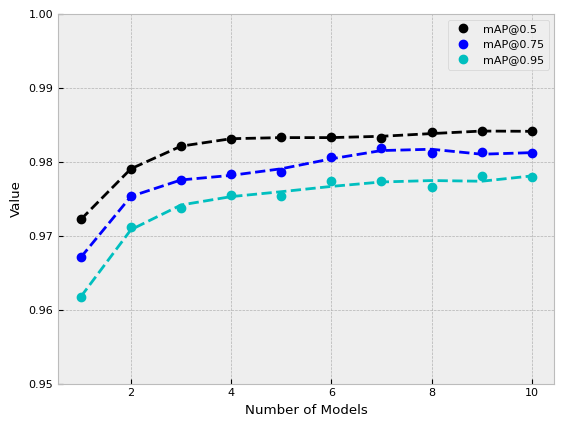

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight': 'normal',	'size': 8}
%matplotlib inline


def plota_results(results, color, label):
    matplotlib.rc('font', **font)
    matplotlib.style.use('bmh')
    z = np.polyfit(list(range(1,len(results)+1)), results, 5)
    p = np.poly1d(z)

    # plot the data and the trend line
    plt.plot(list(range(1,len(results)+1)), results, color+'o', label=label)
    plt.plot(list(range(1,len(results)+1)), p(list(range(1,len(results)+1))), color+'--')#, label='Trend line ' + label)


    #plt.plot(results, 'o')


results05 = [res for i in range(len(results)) for res in [results[i]['0.5'][0]]]
results075 = [res for i in range(len(results)) for res in [results[i]['0.75'][0]]]
results095 = [res for i in range(len(results)) for res in [results[i]['0.95'][0]]]
print(results05)
print(results075)
print(results095)

plota_results(results05, 'k', 'mAP@0.5')
plota_results(results075, 'b', 'mAP@0.75')
plota_results(results095, 'c', 'mAP@0.95')
plt.legend()
plt.ylim(0.95,1)
plt.xlabel('Number of Models')
plt.ylabel('Value')
plt.savefig('wbf.pdf')
plt.show()


[0.9707861974500215, 0.9777901001858746, 0.9803760719503969, 0.9812743354199157, 0.9815708197567747, 0.9825465117387884, 0.9828682969681987, 0.982931249387076, 0.9832033643423723, 0.983208072266626]


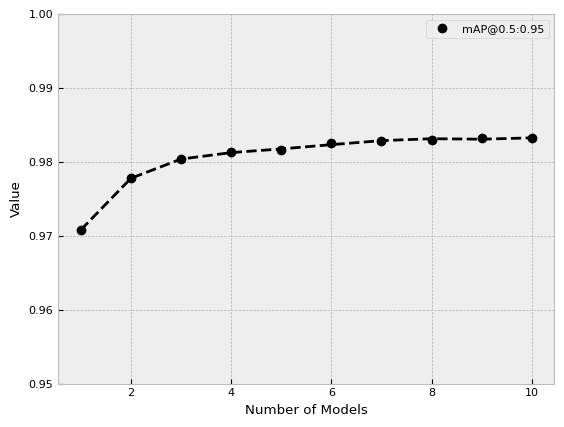

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight': 'normal',	'size': 8}
%matplotlib inline


def plota_results(results, color, label):
    matplotlib.rc('font', **font)
    matplotlib.style.use('bmh')
    z = np.polyfit(list(range(1,len(results)+1)), results, 5)
    p = np.poly1d(z)

    # plot the data and the trend line
    plt.plot(list(range(1,len(results)+1)), results, color+'o', label=label)
    plt.plot(list(range(1,len(results)+1)), p(list(range(1,len(results)+1))), color+'--')#, label='Trend line ' + label)


    #plt.plot(results, 'o')


resultsRange = [res for i in range(len(results)) for res in [results[i]['range'][0]]]
print(resultsRange)
plota_results(resultsRange, 'k', 'mAP@0.5:0.95')
plt.legend()
plt.ylim(0.95,1)
plt.xlabel('Number of Models')
plt.ylabel('Value')
plt.savefig('wbfRange.pdf')
plt.show()


[0.9722025241283444, 0.9790419754456607, 0.9821856729957829, 0.9830228534372464, 0.9833106553311934, 0.9834039297028664, 0.9832364657784193, 0.9839780658915278, 0.9841060527746357, 0.9841352632961646]
[0.9707861974500215, 0.9777901001858746, 0.9803760719503969, 0.9812743354199157, 0.9815708197567747, 0.9825465117387884, 0.9828682969681987, 0.982931249387076, 0.9832033643423723, 0.983208072266626]


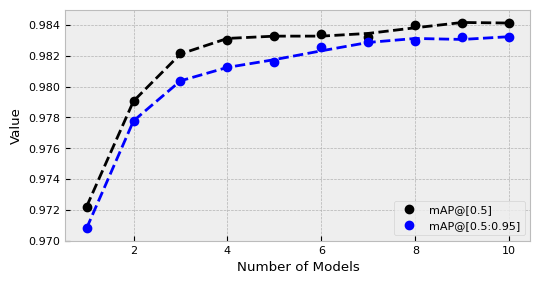

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'weight': 'normal',	'size': 8}
%matplotlib inline


def plota_results(results, color, label):
    matplotlib.rc('font', **font)
    matplotlib.style.use('bmh')
    z = np.polyfit(list(range(1,len(results)+1)), results, 5)
    p = np.poly1d(z)

    # plot the data and the trend line
    plt.plot(list(range(1,len(results)+1)), results, color+'o', label=label)
    plt.plot(list(range(1,len(results)+1)), p(list(range(1,len(results)+1))), color+'--')#, label='Trend line ' + label)


    #plt.plot(results, 'o')


results05 = [0.9722025241283444, 0.9790419754456607, 0.9821856729957829, 0.9830228534372464, 0.9833106553311934, 0.9834039297028664, 0.9832364657784193, 0.9839780658915278, 0.9841060527746357, 0.9841352632961646]
results075 = [0.9707861974500215, 0.9777901001858746, 0.9803760719503969, 0.9812743354199157, 0.9815708197567747, 0.9825465117387884, 0.9828682969681987, 0.982931249387076, 0.9832033643423723, 0.983208072266626]
print(results05)
print(results075)

plt.figure(figsize=(6, 3))
plota_results(results05, 'k', 'mAP@[0.5]')
plota_results(results075, 'b', 'mAP@[0.5:0.95]')
plt.legend(loc='lower right')
plt.ylim(0.97,0.985)
plt.xlabel('Number of Models')
plt.ylabel('Value')
plt.savefig('wbf.pdf')
plt.show()

In [ ]:
!pip install -q grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=ecf6020e67c6d3650efac54141062d5d2c0dbc94dceed50fc8dd76618f660a95
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [ ]:
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        #print('here', x)
        #print(self.model(x))
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model#.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        #if self.cuda:
        #    self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if isinstance(outputs, tuple):
            outputs = outputs[-1][-1]
        #print(outputs)
        if targets is None:

            target_categories = np.argmax(outputs.cpu(), axis=-1)
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.model.zero_grad()
            loss = sum([target(output)
                       for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth).cpu()

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.cpu().numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True
class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(EigenCAM, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        #print(activations)
        return get_2d_projection(activations)



In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
#from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

#from pytorch_grad_cam import DeepFeatureFactorization
#from pytorch_grad_cam.utils.image import show_factorization_on_image


COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    return results[0].boxes.xyxyn, [1, 2, 3, 4], results[0].names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

import os 

#model = torch.hub.load('.', 'custom', path='/exp/weights/final.pt', source='local') 
#model = modelinho

model = YOLO('exp/weights/last.pt')
model.model.eval()
target_layers = [model.model.model[-2]]

folder_path = 'valid/images/'
def plota_eigen(interesse, nome):
    #image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
    img = np.array(Image.open(folder_path + interesse))
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    tensor = transform(img).unsqueeze(0)

    results = model([rgb_img])
    #boxes, colors, names = parse_detections(results)
    #detections = draw_detections(boxes, colors, names, rgb_img.copy())
    #Image.fromarray(detections)

    #cv2.imwrite("detections.jpg", detections)

    #print(results[0].speed)
    #print(target_layers)
    cam = EigenCAM(model.model, [model.model.model[-2]], use_cuda=False)
    tensor = tensor.to('cuda')
    grayscale_cam = cam(tensor)[0, :, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    saida = Image.fromarray(cam_image)
    # Convert the PIL image to a NumPy array
    image_array = np.array(saida)

    # Convert the image color space from RGB to BGR
    image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    #show_image(image_bgr)
    cv2.imwrite(nome+'_eigen.png', image_bgr)

    #cv2.imwrite("cam.jpg", cam_image)

    def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1] 
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
        return image_with_bounding_boxes


    #renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
    #Image.fromarray(renormalized_cam_image)

    #cv2.imwrite('saida_paper2/' + file_name, renormalized_cam_image)
    #plt.show()
    #plt.show()

In [ ]:
for fil in files:
    try:
        fil = fil[:-4]
        interesse = fil+'.jpg'
        nome = 'resultados/'+fil
        plota_interesse(interesse, nome)
        plota_eigen(interesse, nome)
    except:
        print('imagem falhou')


image 1/1 /content/valid/images/160442d_JPG_jpg.rf.8dc44284ff609da26494c26890e2b194.jpg: 640x640 1 flashover_damage, 6 good_insulators, 1 insulator_string, 13.8ms
Speed: 0.6ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 flashover_damage, 6 good_insulators, 1 insulator_string, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/160165_JPG_jpg.rf.a94a4a0941e6b147f13a54586d45b210.jpg: 640x640 1 broken_shell, 30 good_insulators, 1 insulator_string, 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 broken_shell, 30 good_insulators, 1 insulator_string, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/140021_JPG_jpg.rf.2d71911ffcdf60843a79ac800a57049d.jpg: 640x640 1 flashover_damage, 3 good_insulators,

imagem falhou



image 1/1 /content/valid/images/161515_JPG_jpg.rf.48b291eaacdd215bdd0ea08cb61c4461.jpg: 640x640 3 broken_shells, 11 good_insulators, 2 insulator_strings, 14.5ms
Speed: 0.6ms preprocess, 14.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 broken_shells, 12 good_insulators, 2 insulator_strings, 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/161235v_JPG_jpg.rf.97c7853157e7037e5974dcc3597085db.jpg: 640x640 1 flashover_damage, 3 good_insulators, 1 insulator_string, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 flashover_damage, 3 good_insulators, 1 insulator_string, 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/130107h_jpg.rf.f99a35775dcaeb631f67e9e9028b020a.jpg: 640x640 1 broken_shell, 5 good_insulators, 1 

imagem falhou



image 1/1 /content/valid/images/100268d_JPG_jpg.rf.f9e4c1f817eef175bc44bf57c57e2534.jpg: 640x640 1 broken_shell, 6 good_insulators, 1 insulator_string, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 broken_shell, 6 good_insulators, 1 insulator_string, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/150693--2-v_JPG_jpg.rf.70aebd697b0e58687da4732da98e17e5.jpg: 640x640 1 flashover_damage, 14 good_insulators, 1 insulator_string, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 flashover_damage, 14 good_insulators, 1 insulator_string, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/160408_JPG_jpg.rf.aec14a9cd120280d5dc792dbe3e82ec4.jpg: 640x640 1 broken_shell, 9 good_insulators

imagem falhou



image 1/1 /content/valid/images/170041h_JPG_jpg.rf.562d812dcd297b280416db608fd069ac.jpg: 640x640 1 flashover_damage, 10 good_insulators, 2 insulator_strings, 14.3ms
Speed: 0.6ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 flashover_damage, 10 good_insulators, 2 insulator_strings, 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/170183v_JPG_jpg.rf.046062d14573b97a9bb6fe6a92f2c803.jpg: 640x640 6 flashover_damages, 10 good_insulators, 1 insulator_string, 14.5ms
Speed: 0.6ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 good_insulators, 1 insulator_string, 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/150462_JPG_jpg.rf.caad26ee46bf83f4cc8a6608b163a2a3.jpg: 640x640 1 broken_shell, 15 good_insulators, 1 insula